In [1]:
# default_exp domains

# Domains

Once the data is loaded, it is important to visualize all of the tests in their relative contexts.
No single tests will hold all of the answers for a domain.

A useful interactive visualization system has the following properties:
 - Handles creating and arranging multiple figures
   - Handle passing raw data to transforms for normalization
   - Handle generating axes
 - Maintains a common data source for linked brushing
 - Can export selections (future)

Let's load in our large dataset and start playing with the full data to workout bugs.

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
#export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from autoneuro.calculators import TestCalculator


In [4]:
all_neuro = pd.read_excel('data/neuro_data.xlsx',
                          na_values=['na', '-', 'nd']).groupby(['VisitDate', 'PatientID']).first()
all_neuro.replace({'Race': {2: 'AA',
                            1: 'white',
                            3: 'asian'},
                   'Sex': {1: 'male', 2: 'female'}},
                  inplace=True)

COLUMN_MAPPING = {'BVMTtrial1': 'trial1', 'BVMTtrial2': 'trial2', 'BVMTtrial3': 'trial3',
                  'BVMTdelay': 'delay',
                  'BVMThits': 'hits', 'BVMTfalsepos': 'false_pos',
                  'Sex': 'gender', 'Race': 'race',
                  'Education': 'education', 'Age': 'age'}

all_neuro.head()


Visit  Age     Sex Race Race_specify  Education  \
VisitDate  PatientID                                                    
2013-09-24 A0091        1.0   36    male   AA          NaN         16   
           A0107        1.0   49  female   AA          NaN         12   
           A0138        1.0   53  female   AA          NaN         11   
2013-10-03 A0165        1.0   62    male   AA          NaN         12   
2013-10-08 A0127        1.0   62    male   AA          NaN         16   

                      EngFluency  SpanFluency  MMSE  DigitBackwardSENAS  ...  \
VisitDate  PatientID                                                     ...   
2013-09-24 A0091             3.0          0.0  27.0                 6.0  ...   
           A0107             3.0          0.0  27.0                 3.0  ...   
           A0138             3.0          0.0   NaN                 NaN  ...   
2013-10-03 A0165             3.0          0.0  29.0                 5.0  ...   
2013-10-08 A0127             3.0          0.0  28.0                 2.0  ...   

                      Professional  Homeowner  Householdsize  Earnings.Indiv  \
VisitDate  PatientID                                                           
2013-09-24 A0091               NaN        NaN            NaN             NaN   
           A0107               NaN        NaN            NaN             NaN   
           A0138               NaN        NaN            NaN             NaN   
2013-10-03 A0165               NaN        NaN            NaN             NaN   
2013-10-08 A0127               NaN        NaN            NaN             NaN   

                      Income.Indiv  Earnings.House  Income.House  \
VisitDate  PatientID                                               
2013-09-24 A0091               NaN             NaN           NaN   
           A0107               NaN             NaN           NaN   
           A0138               NaN             NaN           NaN   
2013-10-03 A0165               NaN             NaN           NaN   
2013-10-08 A0127               NaN             NaN           NaN   

                      Income.House.Weighted1  Income.House.Weighted2  Effort  
VisitDate  PatientID                                                          
2013-09-24 A0091                         NaN                     NaN     1.0  
           A0107                         NaN                     NaN     NaN  
           A0138                         NaN                     NaN     1.0  
2013-10-03 A0165                         NaN                     NaN     NaN  
2013-10-08 A0127                         NaN                     NaN     NaN  

[5 rows x 163 columns]

This system will be built by visualizations which match to specific neurological tests.
These tests will be the base of this system.
In the abstract, a test defines a set of measurement fields and how they relate.
Then it can generate visualization modules both the raw and normalized fields as needed.
A collection of these `TestCalculator` objects will be combined into a `Domain`.

In [5]:
import yaml

bvmt_test_definition = 'data/test_calculators/BVMT.yaml'
bvmt_calc = TestCalculator.from_config(yaml.full_load(open(bvmt_test_definition)))

heaton_norm_definition = 'data/norms/from_kate/heaton_bvmt.yaml'
heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))

norman_scaling_definition = 'data/norms/norman/norman_scaling.yaml'
norman_scale = TestCalculator.from_config(yaml.full_load(open(norman_scaling_definition)))

norman_regression_definition = 'data/norms/norman/norman_bvmt_regnorm.yaml'
reg_calc = TestCalculator.from_config(yaml.full_load(open(norman_regression_definition)))

full_bvmt_calc = bvmt_calc + heaton_bvmt_calc + norman_scale + reg_calc




In [6]:
#export
from bokeh.transform import factor_cmap, factor_mark
from bokeh.models import BooleanFilter, CDSView, BoxAnnotation, Band, IndexFilter, BooleanFilter, FactorRange
from bokeh.models import Legend, LegendItem

from bokeh.models import ColumnDataSource, HoverTool, Range1d
from bokeh.plotting import figure
from bokeh.layouts import gridplot, layout
from bokeh.io import show

In [7]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

Those tests will likely become more complicated and less "abstract" as we go.
But they're enough to represent each test and contain the information we need.

Now that we have a way of representing tests, lets merge them into domains and start visualizing.


In [8]:
#export

import os
from itertools import chain

class AbstractDomain(object):

    source = None
    data = None
    ranges = {}
    tools = "pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

    def __init__(self, calculator):
        """

        Parameters
        ----------
        calculator : TestCalculator
        """

        self.calculator = calculator

    def _load_data(self):
        pass

    def load_data(self, data, mapping=None):
        self.data = self.calculator.process_dataframe(data, mapping=mapping)
        self._load_data()
        self.source = ColumnDataSource(self.data)

    def build_scatter_fig(self, x = None, y = None,
                          fig = None, scatter_kwargs = None):

        x_range = self.ranges.get(x, Range1d(-10, 10))
        y_range = self.ranges.get(y, Range1d(-10, 10))
        default = {'x_range': x_range, 'y_range': y_range, 'tools': self.tools}
        if fig is None:
            fig = figure(**default)
        elif type(fig) == dict:
            fig = figure(**fig, **default)

        scatter_kwargs = {} if scatter_kwargs is None else scatter_kwargs
        fig.scatter(x = x, y = y, source = self.source,
                    **scatter_kwargs)
        fig.xaxis.axis_label = x
        fig.yaxis.axis_label = y

        self.ranges[x] = fig.x_range
        self.ranges[y] = fig.y_range

        return fig



class MemoryDomain(AbstractDomain):


    @staticmethod
    def from_defaults(root_data = 'data/'):

        bvmt_test_definition = os.path.join(root_data, 'test_calculators/BVMT.yaml')
        bvmt_calc = TestCalculator.from_config(yaml.full_load(open(bvmt_test_definition)))

        heaton_norm_definition = os.path.join(root_data, 'norms/from_kate/heaton_bvmt.yaml')
        heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))

        norman_scaling_definition = os.path.join(root_data,'norms/norman/norman_scaling.yaml')
        norman_scale = TestCalculator.from_config(yaml.full_load(open(norman_scaling_definition)))

        norman_regression_definition = os.path.join(root_data, 'norms/norman/norman_bvmt_regnorm.yaml')
        reg_calc = TestCalculator.from_config(yaml.full_load(open(norman_regression_definition)))

        full_bvmt_calc = bvmt_calc + heaton_bvmt_calc + norman_scale + reg_calc

        return MemoryDomain(full_bvmt_calc)

    def build_delay_immed_fig(self, fig_kwargs = None):
        kwargs = {'title': 'BVMT Immediate vs delay'}
        fig_kwargs = {} if fig_kwargs is None else fig_kwargs
        kwargs.update(fig_kwargs)

        return self.build_scatter_fig(x = 'heaton_immediate', y = 'heaton_delay',
                                      fig = kwargs, scatter_kwargs = None)

    def build_norman_delay_immed_fig(self, fig_kwargs = None):
        kwargs = {'title': 'Norman Immediate vs delay'}
        fig_kwargs = {} if fig_kwargs is None else fig_kwargs
        kwargs.update(fig_kwargs)

        return self.build_scatter_fig(x = 'norman_immediate', y = 'norman_delay',
                                      fig = kwargs, scatter_kwargs = None)

    def build_immed_compare_fig(self, fig_kwargs = None):
        kwargs = {'title': 'Norman Immediate vs Heaton Immedaite'}
        fig_kwargs = {} if fig_kwargs is None else fig_kwargs
        kwargs.update(fig_kwargs)

        return self.build_scatter_fig(x = 'norman_immediate', y = 'heaton_immediate',
                                      fig = kwargs, scatter_kwargs = None)

    def build_delay_compare_fig(self, fig_kwargs = None):
        kwargs = {'title': 'Norman delay vs Heaton delay'}
        fig_kwargs = {} if fig_kwargs is None else fig_kwargs
        kwargs.update(fig_kwargs)

        return self.build_scatter_fig(x = 'norman_delay', y = 'heaton_delay',
                                      fig = kwargs, scatter_kwargs = None)

    def build_immed_recog_fig(self, fig_kwargs = None):
        kwargs = {'title': 'BVMT Immed vs recog'}
        fig_kwargs = {} if fig_kwargs is None else fig_kwargs
        kwargs.update(fig_kwargs)

        return self.build_scatter_fig(x = 'heaton_immediate', y = 'heaton_recognition',
                                      fig = kwargs, scatter_kwargs = None)

    def build_immed_retention_fig(self, fig_kwargs = None):
        kwargs = {'title': 'BVMT Immed vs recog'}
        fig_kwargs = {} if fig_kwargs is None else fig_kwargs
        kwargs.update(fig_kwargs)

        return self.build_scatter_fig(x = 'heaton_immediate', y = 'heaton_retention',
                                      fig = kwargs, scatter_kwargs = None)


    def build_figs(self, fig_kwargs=None):

        lyout = [[self.build_delay_immed_fig(fig_kwargs=fig_kwargs),
                  self.build_immed_recog_fig(fig_kwargs=fig_kwargs),
                  self.build_immed_retention_fig(fig_kwargs=fig_kwargs)],
                 [self.build_norman_delay_immed_fig(fig_kwargs=fig_kwargs),
                  self.build_immed_compare_fig(fig_kwargs=fig_kwargs),
                  self.build_delay_compare_fig(fig_kwargs=fig_kwargs)]]

        return lyout


In [9]:
domain = MemoryDomain.from_defaults()
domain.load_data(all_neuro, mapping=COLUMN_MAPPING)

In [10]:
domain.data.head()


age  delay  education  false_pos  gender  hits race  \
VisitDate  PatientID                                                        
2013-09-24 A0091       36    NaN         16        NaN    male   NaN   AA   
           A0107       49    NaN         12        NaN  female   NaN   AA   
           A0138       53    NaN         11        NaN  female   NaN   AA   
2013-10-03 A0165       62    6.0         12        0.0    male   5.0   AA   
2013-10-08 A0127       62    6.0         16        0.0    male   6.0   AA   

                      trial1  trial2  trial3  ...  heaton_immediate  \
VisitDate  PatientID                          ...                     
2013-09-24 A0091         NaN     NaN     NaN  ...               NaN   
           A0107         NaN     NaN     NaN  ...               NaN   
           A0138         NaN     NaN     NaN  ...               NaN   
2013-10-03 A0165         6.0     6.0     7.0  ...         -0.679035   
2013-10-08 A0127         5.0     6.0     9.0  ...         -0.493506   

                      heaton_retention  heaton_delay  heaton_recognition  \
VisitDate  PatientID                                                       
2013-09-24 A0091                   NaN           NaN                 NaN   
           A0107                   NaN           NaN                 NaN   
           A0138                   NaN           NaN                 NaN   
2013-10-03 A0165             -0.917898     -1.215962           -1.954545   
2013-10-08 A0127             -3.107280     -1.215962            0.318182   

                      norman_gender  norman_race  delay_scaled  \
VisitDate  PatientID                                             
2013-09-24 A0091                0.0          1.0           NaN   
           A0107                1.0          1.0           NaN   
           A0138                1.0          1.0           NaN   
2013-10-03 A0165                0.0          1.0           5.0   
2013-10-08 A0127                0.0          1.0           5.0   

                      immediate_scaled  norman_immediate  norman_delay  
VisitDate  PatientID                                                    
2013-09-24 A0091                   NaN               NaN           NaN  
           A0107                   NaN               NaN           NaN  
           A0138                   NaN               NaN           NaN  
2013-10-03 A0165                   7.0          0.725010      0.169685  
2013-10-08 A0127                   7.0          0.283938     -0.190199  

[5 rows x 24 columns]

In [11]:
FIG_SIZE = {'plot_height': 300,
            'plot_width': 300}

lyout = domain.build_figs(fig_kwargs=FIG_SIZE)


show(layout(lyout))

<AxesSubplot:xlabel='heaton_immediate', ylabel='norman_immediate'>

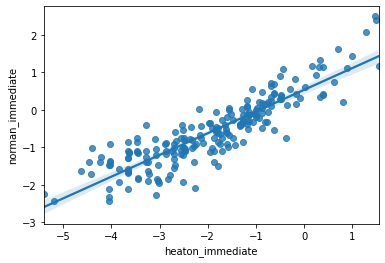

In [12]:
sbn.regplot(y = domain.data['norman_immediate'],
            x = domain.data['heaton_immediate'])

<AxesSubplot:xlabel='heaton_delay', ylabel='norman_delay'>

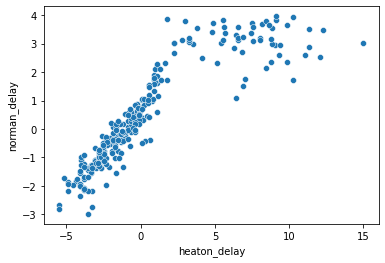

In [13]:
sbn.scatterplot(y = domain.data['norman_delay'],
                x = domain.data['heaton_delay'].clip(upper = 15))


In [14]:
domain.data.columns

Index(['age', 'delay', 'education', 'false_pos', 'gender', 'hits', 'race',
       'trial1', 'trial2', 'trial3', 'immediate', 'retention_denom',
       'retention', 'recognition', 'heaton_immediate', 'heaton_retention',
       'heaton_delay', 'heaton_recognition', 'norman_gender', 'norman_race',
       'delay_scaled', 'immediate_scaled', 'norman_immediate', 'norman_delay'],
      dtype='object')

In [15]:
cols = ['heaton_immediate', 'heaton_retention',
        'heaton_delay', 'heaton_recognition',
        'norman_immediate', 'norman_delay', 'age', 'gender', 'race', 'education']
domain.data[cols].reset_index().to_excel('processed_memory.xlsx', index=False)